In [2]:
!pip install transformers==4.40.1 accelerate==0.30.0 bitsandbytes==0.43.1 auto-gptq==0.7.1 autoawq==0.2.5 optimum==1.19.1 -qqq

# 모델 경량화
- 서비스를 위해 LLM을 배포하는 경우 GPU cost가 가장 많다.
- 경량화는 모델의 성능을 희생하고 cost를 낮추는 방법과 모델의 성능을 유지하고 연산 과정에서 비효율을 줄이는 방법으로 구분할 수 있다.

### 언어 모델 추론

#### 언어 모델이 언어를 생성하는 방법
- 언어 모델은 입력한 텍스트 다음에 올 토큰의 확률을 계산하고 그중에서 가장 확률이 높은 토큰을 입력 텍스트에 추가하면서 한 토큰씩 생성한다.
- '고양이가 밥을' 이라는 텍스트를 입력했을 때 '그리고'가 나올 확률 0.001,'먹고'가 나올 확률이 0.9라고 예측 했다면 '먹고'를 다음 토큰으로 결정하고 '고양이가 밥을 먹고'라는 텍스트를 생성한다.
- 텍스트 생성을 마치는 이유는 두가지다. 다음 토큰 생성 종료를 의미하는 특수토큰(EOS)을 생성하는 경우 생성을 종료한다. 또는 최대길이로 설정한 길이에 도달하면 생성을 종료한다.
- 언어 모델이 텍스트 생성 시 한토큰씩만 생성할 수 있고 다음 토큰,그다음 토큰을 함께 예측할 수 없다. 이처럼 언어 모델은 입력 텍스트를 기반으로 다음 토큰만 예측하는 **자기 회귀적** 특성을 갖는다.
- 하지만 '고양이가 밥을' 같은 프롬프트는 이미 작성된 텍스트이기 때문에 하나씩 토큰 처리할 필요 없이 동시에 병렬적으로 처리할 수 있다. 따라서 **프롬프트가 길다고 해도 다음 토큰 1개를 생성하는 시간과 비슷한 시간이 걸린다.** <span style="background-color:yellow">**이런 이유로 추론 과정을 프롬프트 처리 단계인 사전 계산단계(prefill phase)와 이후 한 토큰씩 생성하는 디코딩단계(decoding phase)로 구분한다.**</span><br>
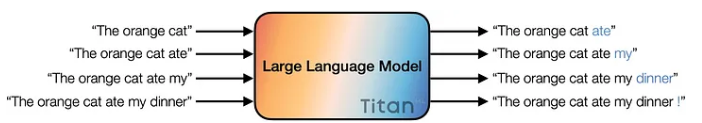

#### 중복연산을 줄이는 KV 캐시
- **KV 캐시**는 셀프 어텐션 연산 과정에서 동일한 입력 토큰('The','orange','cat')에 대해 중복 계산이 발생하느 비효율을 줄이기 위해 먼저 계산했던 키와 값 결과를 메모리에 저장해 활용하는 방법을 말한다. <span style='background-color:yellow'>키와 값 계산 결과를 저장하기 때문에 KV(Key-Value) 캐시 </span>
- 'The orange cat'을 입력했을 때 다음 토큰으로 'ate'를 예측하고 그 다음 토큰을 예측하는 중일 때 **KV 캐시 사용 하지 않는 경우 이전 수행한 'The orange cat '을 키와 값 벡터로 변환하는 동일한 연산을 반복해야한다. KV 사용 시 'The','orange','cat'은 KV 캐시에서 계산 결과를 가져와 사용하고 새로운 토큰인 'ate'만 새롭게 연산한다.**<br>
- 아래와 같이 13B 모델을 fp16데이터 형식으로 불러와 파라미터 저장에 26GB메모리를 사용하고 순전파 연산에 필요한 메모리(Others),나머지는 KV 캐시로 사용한다.<br>
  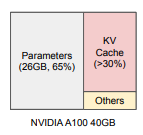
- 캐시를 저장하기 위한 메모리 양은<span style=background-color:yellow>**$$KV 캐시 메모리=2byte\times2(key,value)\times(레이어 수)\times(토큰 임베딩 차원)\times(최대 시퀀스길이)\times(배치크기)$$**</span>  <br>
- 처음 2byte는 fp16 형식을 사용하기 때문에 2를 곱한다. KV캐시는 키,값 2개를 저장하므로 2를 곱해준다. 셀프 어텐션 연산 결과는 어텐션 레이어 수만큼 생기기 때문에 레이어 수를 곱해준다. 토큰 임베딩 표현 차원수만큼 수를 저장하기 때문에 토큰 임베딩 차원을 곱한다. 최대 생성 시퀀스 길이 만큼 메모리 확보를 위해 최대 시퀀스 길이를 곱하고, 배치 크기가 커질수록 저장 데이터가 많아지기 때문에 배치 크기를 곱한다.
- 파라미터가 130억개인 llama2 13B 모델에서 확인한다면 레이어수는 40, 토큰 임베딩 차원 5120,최대 시퀀스 길이 4096 인데 KV 캐시 저장 사용 메모리는 1배치당 2.5GB이다. 그림에서 40GB 메모리중 모델 저장에 26GB을 사용했기 때문에 최대 14GB 메모리 사용할 수 있다. 최대 배치크기는 5정도다.

#### GPU 구조와 최적 배치 크기
- 모델 서빙이 효율적인지 판단하는 큰 기준은 비용,처리량(시간당 처리한 요청 수,query/s),지연시간(하나 토큰 생성하는데 걸리는 시간,token/s)이 있다.<br>
 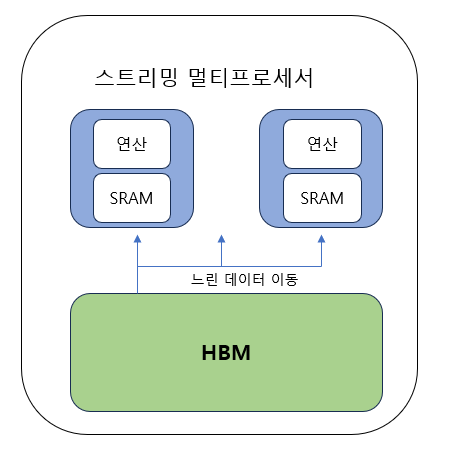 <br>
- 하나의 GPU는 여러 스트리밍 멀티프로세서(SM)로 구성되어 있고 하나의 SM에는 연산을 수행하는 부분과 값을 저장하는 **SRAM**이 있다. SRAM은 L1캐시 또는 공유 메모리 라고 부르기도 한다. 연산수행과 SRAM은 큰 메모리를 갖기 어렵기 때문에 **고대역폭 메모리(HBM)에 큰 데이터를 저장한다.** 흔히 "GPU 메모리가 16GB다,40GB다 "라고 할때의 메모리는 HBM을 말한다.<br>
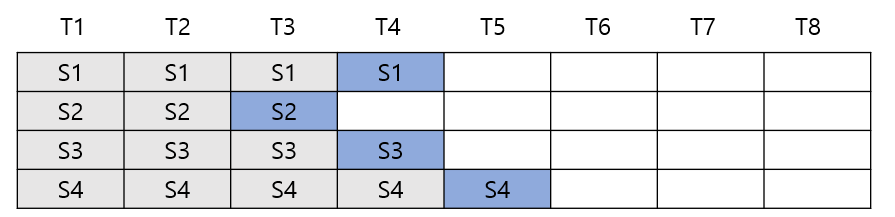
- 추론을 수행할 때는 배치 크기만큼의 토큰을 한 번에 생성한다. 그림에서 입력 배치의 각 문장($S$)은 길이가 서로 다른데, 추론 수행 시 각 프롬프트 토큰(회색토큰)의 뒤로 새롭게 생성한 토큰(파랑 토큰)이 더해진다. <span style="color:blue">**KV 캐시를 사용하면 회색 토큰은 KV 캐시에서 가져오고 파랑 토큰 부분만 실제 계산한다.**</span> **모델 파라미터가 차지하는 메모리를 $P$라고 할 때, 계산량은 대략 $2\times P \times(배치크기)$byte다. 그림에서는 $2\times P \times 4$가 대략적인 연산량이다.<br>
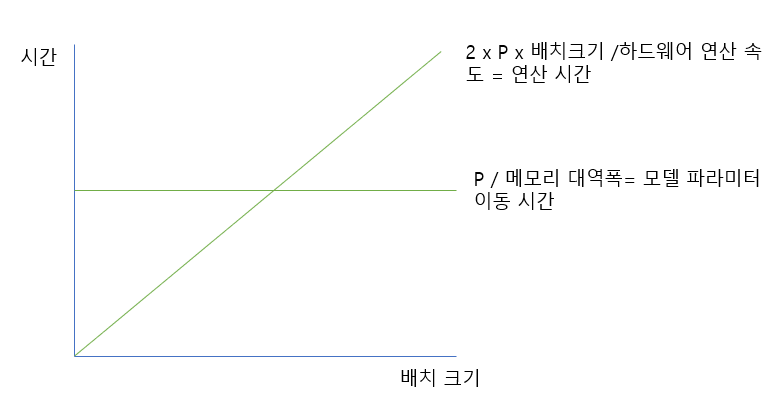
- HBM에 모델을 저장한다고 했는데, 연산 수행을 위해 SRAM으로 이동시켜야 한다. 즉 $P$만큼 메모리를 이동시키는데 시간이 걸린다. 배치 크기가 커지면 연산에 필요한 시산은 증가하지만, 모델 파라미터의 이동에 걸리는 시간은 변함 없다. **모델 이동 과정과 연산 수행 과정은 같이 진행되기 때문에 두 가지 시간이 같은 때가 최적의 배치 크기가 된다.**
- **최적의 배치크기 ($B$) 보다 배치 크기가 작으면 모델 파타미터를 이동시키느라 연산이 멈추는 비효율이 생기는데 이런 경우 <span style='color:red'>메모리 바운드(Memory bound)</span>라고 부른다. 반대로 배치 크기가 최적 크기보다 더 커지면 연산시간이 오래 걸리기 떄문에 지연시간이 길어지는데 이런 경우 <span style='color:red'>연산 바운드</span>라고 부른다.**
- GPU를 효율적으로 활용하기 위해서는 최대 배치 크기가 최적의 배치 크기에 가까워질 수 있는 방법을 찾아야하는데, 이는 모델 용량을 줄이는 방법과 KV캐시의 용량을 줄이는 방법으로 나눌 수 있다.

#### KV 캐시 메모리 줄이기
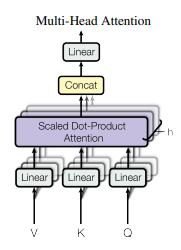
- 멀티헤드어텐션은 한번에 여러 헤드(h)에 대한 연산을 수행하기 때문에 Q와 K사이에 다양한 측면의 관련성을 반영할 수 있고 성능을 높일 수 있었다. 하지만 많은 수의 K,V 벡터를 저장하기 때문에 KV캐시에 더 많은 메모리를 사용하고 KV 캐시에서 더 많은 데이터를 불러와 계산하기 때문에 그만큼 속도가 느려진다.
- 이 단점을 극복하기 위해 **모든 Q 벡터가 하나의 K,V 벡터를 공유하는 <span style='background-color:yellow'>멀티 쿼리 어텐션</span> 이 개발되었다.**<br>
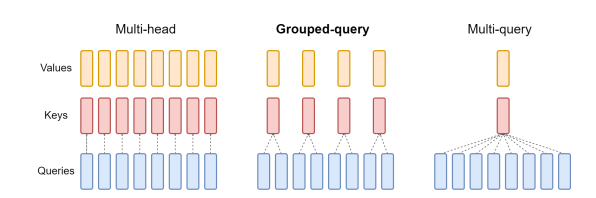<br>
- 멀티 쿼리 어텐션은 (c)와 같이 여러 헤드의 Q 벡터가 하나의 K,V 값벡터를 사용한다. 따라서 (a)의 멀티 헤드 어텐션이 8개의 K,V 벡터를 저장했다면 멀티 쿼리 어텐션은 1개의 K,V 벡터만 저장하기 때문에 KV 캐시를 저장하는 데 훨씬 적은 메모리를 사용한다. 하지만 성능이 떨어지는 문제가 있었다.
- 이 문제를 해결하기 위해 **K,V 수를 줄이지만 멀티 쿼리 어텐션 보다는 많은 K,V를 사용하는** <span style='background-color:yellow'>**그룹 쿼리 어텐션**</span>이 개발 되었다.(b)의 그룹 쿼리 어텐션은 2개의 Q 벡터당 1개의 K,V 벡터를 사용해 결과적으로 4개의 K,V을 사용한다.


### 양자화로 모델 용량 줄이기
양자화(quantization)는 부동소수점 데이터를 더 적은 메모리를 사용하는 경우 정수 형식으로 변환해 GPU를 효율적으로 사용하는 방법<br>
요즘은 모델이 점점 커지면서 16비트 형식(FP16,BF16)을 사용하는 경우가 많다.<br>
16비트 파라미터는 보통 8,4,3비트로 양자화 하는데 최근에는 4비트로 양자화 하고 계산은 16비트로 하는 **$W4A16$**(Weight 4bits and Activation 16bits) 을 주로 활용한다.<br>
양자화는 수행 시점에 따라 <span style='color:blue'>**학습 후 양자화(Post-Training Quantization,PTQ)와 양자화 학습(Quantization-Aware Training,QAT)**</span> 으로 나뉜다.<br>
HuggingFace에서 활발하게 이용되는 양자화는 **비츠앤바이츠,GPTQ,AWQ** 이 세가지이며 모두 학습후 양자화 방식에 해당한다.

#### 비츠앤바이츠(bits-and-bytes)
- 4비트 정규 분포 양자화,8비트 행렬 연산 두가지 양자화 방식이 있다.
- 4비트 양자화 : 가중치,활성값을 양자화 할때 값들이 정규분포를 따른다고 가정하고 이를 기반으로 양자화 하는 방식(Efficient learning with GPUs에서 )
- 8비트 행렬 연산 : 8비트로 연산을 수행하면서 성능 저하가 거의 없이 성능을 유지<br>
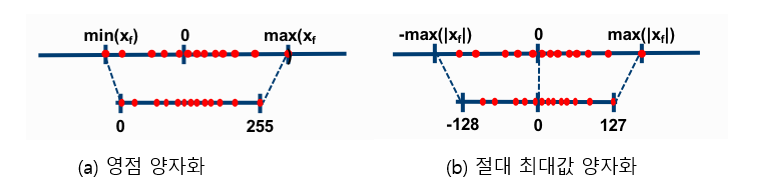
양자화는 데이터의 최대값과 최솟값을 변환하려는 데이터 형식의 변환하는 영점 양자화(zero-point),절대 최대값을 기준으로 대칭적으로 새로운 데이터 타입으로 변환하는 절대 최대값(absmax)양자화 방식을 주로 사용한다.하지만 그대로 적용 시 기존 모델에 비해 성능이 떨어진다.<br>
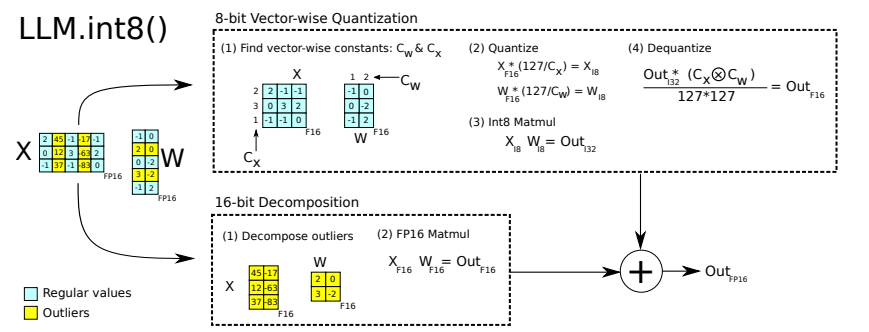
- 비츠앤바이츠는 그림 아래쪽 처럼 $X$의 값 중 크기가 **큰 이상치가 포함된 열은 별도로 분리해서 16비트 그대로 계산했다.(입력에서 값이 큰경우 중요 정보라고 판단해 정보 소실되지 않게 양자화 하지 않고 그대로 연산)**,다음으로 정상 수치 열을 양자화 할 때 벡터단위로 절대 최댓값을 찾고 행별로 큰 값을 찾으면(2,3,-1)이기 때문에 양자화 상수 $C_x$를 (2,3,1)로 잡았다. 다음으로 가중치 $W$에서 열별로 절대값이 가장 큰 값을 찾으면 (-1,2)이기 때문에 양자화 상수 $C_w$를 (1,2)로 잡았다. **8비트로 양자화한 정상 값 벡터끼리 행렬곱 하고, 16비트 그대로 사용하는 이상치 벡터끼리 행렬 곱을 수행해 최종적으로 16비트 결과를 산출한다.**


In [2]:
## 비츠앤바이츠 양자화 모델 불러오기
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from transformers import AutoModelForCausalLM,BitsAndBytesConfig
#8비트 양자화
bnb_config_8bit = BitsAndBytesConfig(load_in_8bit = True)
model_8bit = AutoModelForCausalLM.from_pretrained("facebook/opt-350m",quantization_config=bnb_config_8bit)

#4비트 양자화
bnb_config_4bit = BitsAndBytesConfig(load_in_4bit = True,bnb_4bit_quant_type='nf4') #'nf4는 정규분포 가정 양자화'
model_4bit = AutoModelForCausalLM.from_pretrained("facebook/opt-350m",low_cpu_mem_usage=True,quantization_config=bnb_config_4bit)


`low_cpu_mem_usage` was None, now set to True since model is quantized.


#### GPTQ
- GPTQ는 양자화 이전의 모델에 입력 $X$를 넣었을 때화 양자화 이후 모델에 입력$X$를 넣었을 때 오차가 가장 작아지도록 모델 양자화를 수행한다.
- GPTQ는 양자화를 위한 작은 데이터셋을 준비하고 그 데이터셋을 활용해 모델 연산을 수행하면서 양자화 이전과 유사한 결과가 나오도록 모델을 업데이트 한다.<br>
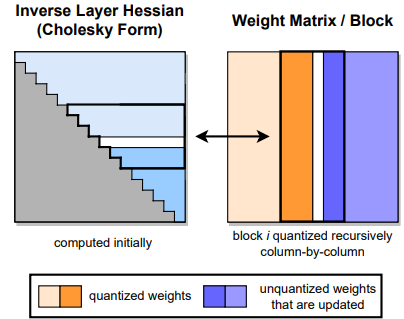<br>
- 오른쪽 박스는 현재 양자화를 수행하는 가중치 행렬이다. 그 중 굵은 박스는 실제 양자화를 수행하는 블록이다. 흰색으로 표현된 부분은 현재 양자화를 수행하는 열이고 해당 열을 기준으로 왼쪽은 이미 양자화를 수행한 열,오른쪽은 다음 양자화를 수행할 열이다.
- **흰색 열의 양자화를 수행하고 양자화를 위해 준비한 데이터를 입력한 결과과 이전과 최대한 가까워지도록 양자화하지않은 오른쪽 부분의 파라미터를 업데이트 한다.왼쪽은 이미 양자화한 열이므로 업데이트 하지 않는다**<br>
<br>
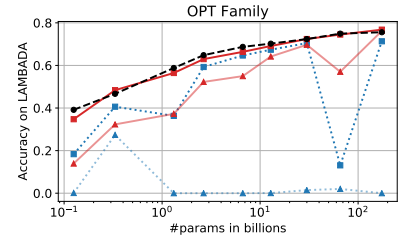
- 3비트 또는 4비트로 변환한 모델의 성능을 16비트의 기존 모델과 비교하면 위와 같다. 3비트 양자화의 경우 성능 저하가 어느정도 있지만 4비트 양자화의 경우 기존 모델과 동일한 성능을 보이는것을 확인 할 수 있다. 성능은 LAMBADA 벤치마크의 정확도를 사용했다.(제시문을 바탕으로 문장의 빈칸을 채우는 문제푸는 능력 평가)

In [ ]:
# GPTQ 양자화 수행 
from transformers import AutoModelForCausalLM,AutoTokenizer,GPTQConfig
model_id = 'facebook/opt-125m'
tokenizer = AUtoTokenizer.from_pretrained(model_id)
quantization_config = GPTConfig(bits=4, dataset='c4',tokenizer=tokenizer)
model = AutoModelForCausalLM.from_pretrained(model_id,device_map='auto',quantization_config=quantization_config)
# 시간이 너무 오래 걸리기 떄문에 허깅페이스 탐색 후 양자화된 모델 
model = AutoModelForCausalLM.from_pretrained("TheBloke/zephyr-7B-beta-GPTQ",device_map='auto',trust_remote_code=False,revision='main')


#### AWQ
- AWQ는 <span style='background-color:yellow'>**모든 파라미터가 동등하게 중요하지 않으며 특별히 중요한 파라미터의 정보를 유지하면 양자화 수행 시 성능저하를 막을 수 있다는 아이디어다**</span>
- 중요한 파라미터를 판단할 수 있는 방법은 **모델 파라미터의 값이 크다**면 연산과정에서도 큰 영향이 있을 확률이 높다. 다른 방법으로는 **입력 데이터의 활성화 값이 큰 채널의 파라미터** 가 중요하다고 가정할 수도 있다.<br>
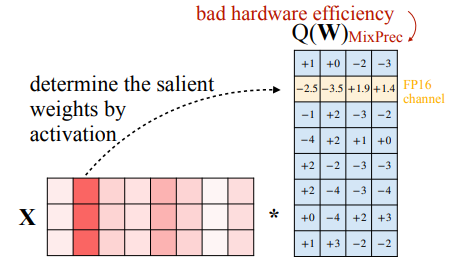<br>
- MIT는 파라미터 자체와 활성화 값을 기준으로 상위 1% 모델 파라미터를 찾고 해당 파라미터는 FP16으로 유지하고 나머지는 양자화 했다. 그 결과 성능저하가 거의 발생하지 않았다.<br>
- 하지만 데이터 **서로다른 데이터 타입이 섞여있는 경우 한번에 일괄 연산하기 어렵기 때문에 연산이 느려지고 효율성이 떨어지는 문제가 발생한다.**<br>
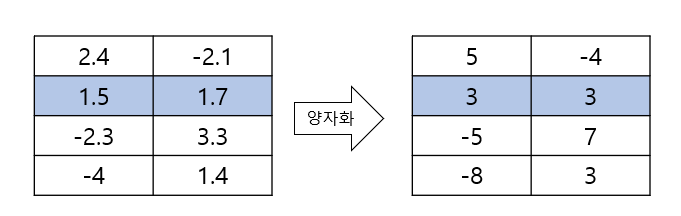<br>
- 2번째 행이 중요 파라미터 이고, 4비트 정수로 양자화 한다고 할 때, 절대 최대값은 4이고 4비트 정수는 -8~7 까지 표현 할 수 있기 때문에 모델 파라미터에 2배를 해주고 반올림하면 양자화를 수행할 수 있다.이때 중요 파라미터인 1.5와 1.7은 2곱하고 반올림 했을 때 둘다 3이 된다. 서로 다른 값이었는데 양자화 수행하면서 값이 같아지고 중요 정보 소실이 되었다고 할 수 있다.<br>
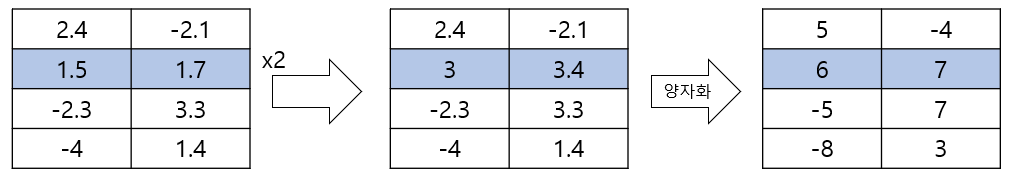<br>
- MIT에서는  <span style='background-color:yellow'>**중요 파라미터에만 1보다 큰 값을 곱하는 방식으로 이 문제를 해결했다. 이때 곱해주는 값을 스케일러(scaler)라고 부른다.**</span> 이렇게 되면 양자화를 수행하면서도 중요 정보가 소실되지 않았다고 이해할 수 있다.<br>
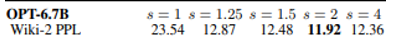<br>
- 스케일러 $s$가 2일 때까지는 성능이 향상되지만 2를 넘어가는 경우 성능이 하락하는 것을 확인할 수 있었다. PPL(perplexity)은 텍스트를 생성할 때 언어 모델이 다음 토큰에 어떤 단어가 올지 확신하지 못하는 혼란도를 나타낸다. 낮을수록 좋다.
- 만약 스케일러를 4로 사용했을 때 모델 파라미터에서 값이 가장 큰 수는 중요 파라미터인 7.8이되고 7.8에 맞춰 나머지 파라미터도 양자화 되기 때문에 더 좁은 범위로 변환되며 정보소실이 발생할 수 있다.

In [ ]:
from awq import AUtoAWQForCausalLM
from transformers import AutoTokenizer

model_name_or_path = 'TheBloke/zephyr-7B-beta-AWQ'
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path,trust_remote_code=False)
model = AutoAWQForCausalLM.from_pretrained(model_name_or_path,fuse_layers=True,trust_remote_code=False,safetensors=True)

### 지식증류 활용
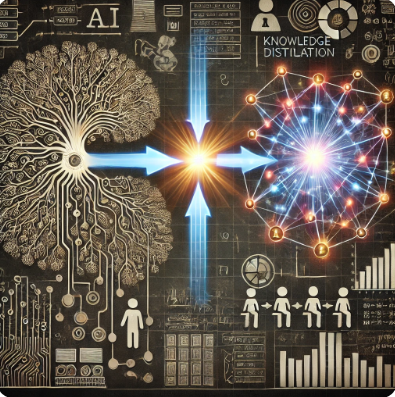<br>
- 지식증류란 더 크고 성능이 높은 teacher model의 생성 결과를 활용해 더 작고 성능이 낮은 student model을 만드는 방법을 말한다.<br>
- GPT-3.5나 GPT-4 같은 언어 모델이 뛰어난 언어 능력을 보이면서 추론 결과를 학생 모델 학습에 활용하는 정도였다면, 최근에는 선생모델을 활용해 완전히 새로운 학습 데이터셋을 대규모로 구축하거나 데이터셋 구축을 선생모델이 수행하는 등 폭넓게 활용되고있다.
- HuggingFace 팀은 제퍼-7B-beta 모델 개발과정에서 지시데이터셋의 구축과 선호데이터셋의 구축 모두 LLM을 사용했다.
- MS의 파이-1 모델을 개발할때 GPT-3.5를 사용해 프로그래밍 학습에 도움이 되는 코드인지 선별하는 작업을 수행했다. 또한 함수의 이름과 함수에 대한 설명인 독스트링을 입력하고 GPT-3.5가 입력에 대응하는 코드를 구현하도록해 코드 예제 데이터셋을 구축했다.